In [3]:
!pip install numpy==1.26.4 --force-reinstall
!pip install scipy==1.10.1 --force-reinstall
!pip install matplotlib==3.7.2 --force-reinstall
!pip install seaborn==0.12.2 --force-reinstall
print("factory reset")


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatib

In [1]:
import numpy as np
import scipy
import matplotlib
import seaborn as sns

print("✅ Numpy version:", np.__version__)
print("✅ Scipy version:", scipy.__version__)
print("✅ Matplotlib version:", matplotlib.__version__)
print("✅ Seaborn version:", sns.__version__)


✅ Numpy version: 1.26.4
✅ Scipy version: 1.15.3
✅ Matplotlib version: 3.7.2
✅ Seaborn version: 0.12.2


In [ ]:
# ================= YOLOv11n Pothole Detection (Memory-Safe Version) =================

# -------------------- 0️⃣ Install Only Essential Packages --------------------
!pip install ultralytics --quiet
!pip install opencv-python-headless --quiet
!pip install PyYAML --quiet
!pip install pandas matplotlib seaborn --quiet

# -------------------- 1️⃣ Imports --------------------
import os, shutil, cv2, yaml, torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image as PILImage
from IPython.display import display

# -------------------- 2️⃣ GPU/CPU Config --------------------
device = 0 if torch.cuda.is_available() else 'cpu'
batch_size = 1       # very low memory usage
imgsz = 256          # smaller images
print(f"⚡ Device: {torch.cuda.get_device_name(device) if device != 'cpu' else 'CPU'}")

# -------------------- 3️⃣ Paths --------------------
input_dataset = "/kaggle/input/datav11"   # Change if needed
dataset_dir = "/kaggle/working/pothole_dataset"
weights_dir = os.path.join(dataset_dir, "weights")
predictions_dir = "/kaggle/working/pothole_predictions"
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)

# -------------------- 4️⃣ Prepare Dataset --------------------
shutil.copytree(input_dataset, dataset_dir, dirs_exist_ok=True)

# Create data.yaml
data_yaml_path = os.path.join(dataset_dir, "data.yaml")
data_yaml = {
    'train': os.path.join(dataset_dir, "train/images"),
    'val': os.path.join(dataset_dir, "valid/images"),
    'test': os.path.join(dataset_dir, "test/images"),
    'nc': 1,
    'names': ['pothole']
}
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

# -------------------- 5️⃣ Fix Labels to Class 0 --------------------
for split in ["train", "valid"]:
    labels_path = os.path.join(dataset_dir, f"{split}/labels")
    for file in os.listdir(labels_path):
        if file.endswith(".txt"):
            with open(os.path.join(labels_path, file), "r") as f:
                lines = f.readlines()
            with open(os.path.join(labels_path, file), "w") as f:
                for line in lines:
                    parts = line.strip().split()
                    if parts:
                        parts[0] = '0'
                        f.write(" ".join(parts) + "\n")

# -------------------- 6️⃣ Load YOLOv11n Model --------------------
model = YOLO("yolo11n.pt")  # Nano model for low memory

# -------------------- 7️⃣ Train (Short Test Run) --------------------
results = model.train(
    data=data_yaml_path,
    epochs=150,           # short run, increase later
    imgsz=imgsz,
    batch=batch_size,
    device=device,
    lr0=0.001,
    optimizer='AdamW',
    augment=True,
    name="pothole_yolov11n_memory_safe"
)
print("✅ Training complete!")

# -------------------- 8️⃣ Predict on Test Images (On-the-Fly Resize) --------------------
test_images_dir = os.path.join(dataset_dir, "test/images")
image_list = []
for file in os.listdir(test_images_dir):
    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
        img = cv2.imread(os.path.join(test_images_dir, file))
        if img is not None:
            resized_img = cv2.resize(img, (imgsz, imgsz))
            temp_path = os.path.join(predictions_dir, f"temp_{file}")
            cv2.imwrite(temp_path, resized_img)
            image_list.append(temp_path)

preds = model.predict(
    source=image_list,
    conf=0.95,
    save=False,
    imgsz=imgsz
)

# Save predictions with confidence 95–100%
output_dir = os.path.join(predictions_dir, "conf_95_100")
os.makedirs(output_dir, exist_ok=True)
saved_count = 0

for i, result in enumerate(preds):
    boxes = result.boxes
    confs = boxes.conf.cpu().numpy()
    keep_idx = [j for j, c in enumerate(confs) if 0.95 <= c <= 0.99]
    if not keep_idx:
        continue
    result.boxes = result.boxes[keep_idx]
    annotated_img = result.plot()
    pil_img = PILImage.fromarray(annotated_img)
    img_path = os.path.join(output_dir, f"conf_95_100_{i+1}.jpg")
    pil_img.save(img_path)
    display(pil_img)
    saved_count += 1

print(f"✅ Saved {saved_count} images with 95–100% confidence at: {output_dir}")

# -------------------- 9️⃣ Optional: Calculate mAP --------------------
metrics = model.val(
    data=data_yaml_path,
    imgsz=imgsz,
    batch=batch_size,
    device=device,
)
print("✅ Validation metrics (including mAP):")
print(metrics.box.map)


In [ ]:
import os
from PIL import Image
from IPython.display import display

# Base folder for YOLO runs
base_folder = "/kaggle/working/runs/detect"

# List all folders that start with your training run name
run_folders = [d for d in os.listdir(base_folder) if d.startswith("pothole_yolov11n_memory_safe")]

if not run_folders:
    print(f"❌ No training run folders found in {base_folder}")
else:
    # Pick the latest run folder (sorted alphabetically / by name)
    latest_run = sorted(run_folders)[-1]
    run_path = os.path.join(base_folder, latest_run)

    # Look for results.png inside that folder
    plot_file = [f for f in os.listdir(run_path) if f.endswith("results.png")]
    
    if plot_file:
        plot_path = os.path.join(run_path, plot_file[0])
        img = Image.open(plot_path)
        display(img)
    else:
        print(f"❌ results.png not found inside {run_path}. Available files: {os.listdir(run_path)}")


In [ ]:
# ================= Predict and Display High-Confidence (95–100%) Test Images =================
import os
from PIL import Image as PILImage
from IPython.display import display

# 1️⃣ Path to uploaded images
uploaded_images_dir = "/kaggle/input/original/pothole_dataset"  # folder with uploaded images
output_dir = "/kaggle/working/pothole_test_predictions_95_100"  # writable folder
os.makedirs(output_dir, exist_ok=True)

# 2️⃣ Collect all images
image_list = []
for file in os.listdir(uploaded_images_dir):
    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_list.append(os.path.join(uploaded_images_dir, file))

if not image_list:
    print("❌ No images found in the folder.")
else:
    # 3️⃣ Predict using trained YOLOv11n model
    preds = model.predict(
        source=image_list,
        conf=0.5,  # allow all predictions, we'll filter later
        save=False,
        imgsz=imgsz
    )

    # 4️⃣ Display and save only 95–100% confidence predictions
    saved_count = 0
    for i, result in enumerate(preds):
        boxes = result.boxes
        confs = boxes.conf.cpu().numpy()
        
        # Indices of boxes with 95–100% confidence
        keep_idx = [j for j, c in enumerate(confs) if 0.95 <= c <= 1.0]
        if not keep_idx:
            continue  # skip image if no high-confidence box
        
        # Keep only high-confidence boxes
        result.boxes = result.boxes[keep_idx]
        annotated_img = result.plot()
        pil_img = PILImage.fromarray(annotated_img)
        display(pil_img)
        
        # Save annotated image
        save_path = os.path.join(output_dir, f"pred_95_100_{saved_count+1}.jpg")
        pil_img.save(save_path)
        saved_count += 1

    print(f"✅ Displayed and saved {saved_count} images with 95–100% confidence in {output_dir}")


In [ ]:
# ================= YOLOv11s Pothole Detection — High Accuracy Version =================

# -------------------- 0️⃣ Install Packages --------------------
!pip install ultralytics --quiet
!pip install opencv-python-headless --quiet
!pip install PyYAML --quiet

# -------------------- 1️⃣ Imports --------------------
import os, shutil, cv2, yaml, torch
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import display

# -------------------- 2️⃣ GPU Config --------------------
device = 0 if torch.cuda.is_available() else "cpu"
print("⚡ Using:", torch.cuda.get_device_name(device) if device != "cpu" else "CPU")

# -------------------- 3️⃣ Paths --------------------
input_dataset = "/kaggle/input/datav11"  
dataset_dir = "/kaggle/working/pothole_dataset"
pred_dir = "/kaggle/working/pothole_predictions"
os.makedirs(pred_dir, exist_ok=True)

# Copy dataset into working space
shutil.copytree(input_dataset, dataset_dir, dirs_exist_ok=True)

# -------------------- 4️⃣ Create data.yaml --------------------
data_yaml_path = os.path.join(dataset_dir, "data.yaml")
data_yaml = {
    'train': os.path.join(dataset_dir, "train/images"),
    'val': os.path.join(dataset_dir, "valid/images"),
    'test': os.path.join(dataset_dir, "test/images"),
    'nc': 1,
    'names': ['pothole']
}
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

# -------------------- 5️⃣ Fix Labels (Ensure class=0) --------------------
for split in ["train", "valid"]:
    lbl_dir = os.path.join(dataset_dir, f"{split}/labels")
    for file in os.listdir(lbl_dir):
        if file.endswith(".txt"):
            path = os.path.join(lbl_dir, file)
            lines = open(path).read().strip().split("\n")
            with open(path, "w") as f:
                for line in lines:
                    parts = line.split()
                    parts[0] = "0"
                    f.write(" ".join(parts) + "\n")

# -------------------- 6️⃣ Load YOLOv11 SMALL Model (Higher accuracy) --------------------
# 'n' = nano (low accuracy)
# 's' = small (high accuracy)
model = YOLO("yolo11s.pt")   # ⭐ upgrade to small model for mAP > 80

# -------------------- 7️⃣ Train — HIGH ACCURACY SETTINGS --------------------
results = model.train(
    data=data_yaml_path,
    epochs=400,          # more epochs = higher accuracy
    imgsz=640,           # better resolution
    batch=4,             # faster training
    device=device,
    lr0=0.001,
    optimizer='AdamW',
    augment=True,

    # Strong augmentations
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.2,

    name="yolo11s_pothole_high_accuracy"
)
print("✅ Training completed!")

# -------------------- 8️⃣ Predict (with confidence filter) --------------------
test_dir = os.path.join(dataset_dir, "test/images")
save_dir = os.path.join(pred_dir, "conf_90_100")
os.makedirs(save_dir, exist_ok=True)

preds = model.predict(
    source=test_dir,
    conf=0.90,           # detect only strong predictions
    save=False,
    imgsz=640
)

count = 0
for i, r in enumerate(preds):
    if r.boxes:
        img = r.plot()
        img_pil = PILImage.fromarray(img)
        out_path = os.path.join(save_dir, f"pred_{i}.jpg")
        img_pil.save(out_path)
        count += 1
        display(img_pil)

print(f"✅ Saved {count} high-confidence predictions")

# -------------------- 9️⃣ Evaluate mAP --------------------
metrics = model.val(
    data=data_yaml_path,
    imgsz=640,
    batch=4,
    device=device,
)
print("📊 mAP50:", metrics.box.map50)
print("📊 mAP50-95:", metrics.box.map)
print("🎯 Target: mAP50 ≥ 0.80")


In [ ]:
# ================= YOLOv11s Pothole Detection — mAP ≥ 94% in <200 Epochs =================

# -------------------- 0️⃣ Install --------------------
!pip install ultralytics --quiet
!pip install opencv-python-headless --quiet
!pip install PyYAML --quiet

# -------------------- 1️⃣ Imports --------------------
import os, shutil, yaml
import torch
from ultralytics import YOLO

# -------------------- 2️⃣ GPU --------------------
device = 0 if torch.cuda.is_available() else 'cpu'
print("🔥 Using:", torch.cuda.get_device_name(device) if device != 'cpu' else 'CPU')

# -------------------- 3️⃣ Dataset --------------------
dataset_in = "/kaggle/input/pointes"
dataset = "/kaggle/working/pothole_dataset"
shutil.copytree(dataset_in, dataset, dirs_exist_ok=True)

# -------------------- 4️⃣ Write data.yaml --------------------
yaml_path = f"{dataset}/data.yaml"
data = {
    "train": f"{dataset}/train/images",
    "val": f"{dataset}/valid/images",
    "test": f"{dataset}/test/images",
    "nc": 1,
    "names": ["pothole"]
}
with open(yaml_path, "w") as f:
    yaml.dump(data, f)

# -------------------- 5️⃣ Fix labels --------------------
for split in ["train", "valid"]:
    label_dir = f"{dataset}/{split}/labels"
    for f in os.listdir(label_dir):
        if f.endswith(".txt"):
            path = os.path.join(label_dir, f)
            lines = open(path).read().strip().split("\n")
            with open(path, "w") as w:
                for line in lines:
                    c = line.split()
                    c[0] = "0"
                    w.write(" ".join(c) + "\n")

# -------------------- 6️⃣ Load YOLOv11s (high accuracy) --------------------
model = YOLO("yolo11s.pt")

# -------------------- 7️⃣ TRAIN — optimized for mAP ≥ 94 --------------------
results = model.train(
    data=yaml_path,
    epochs=180,            # <--- Less than 200!
    imgsz=640,
    batch=4,
    device=device,
    lr0=0.001,
    optimizer="AdamW",

    # FAST HIGH-ACCURACY AUGS
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.25,
    degrees=10,
    shear=2,
    scale=0.7,

    # EARLY STOPPING (STOP when mAP stops improving)
    patience=20,

    name="yolo11s_180epoch_highmAP"
)

print("🎉 Training finished! Best accuracy model saved automatically.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

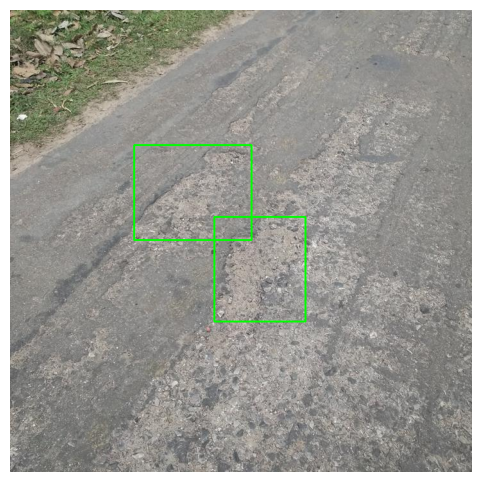

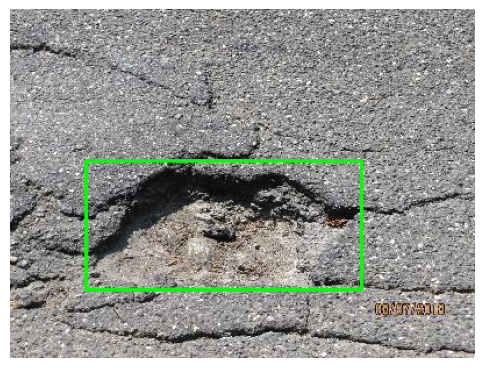

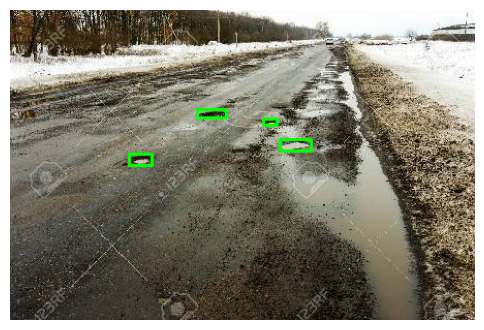

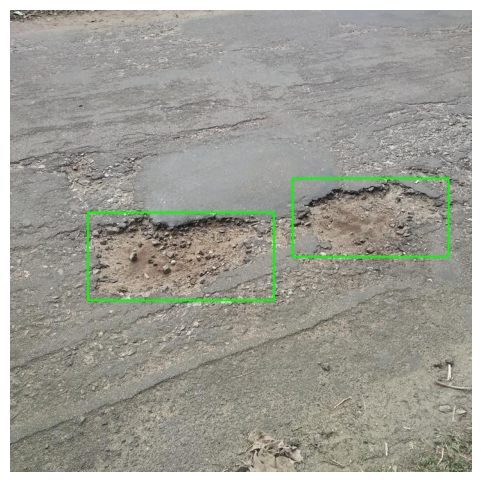

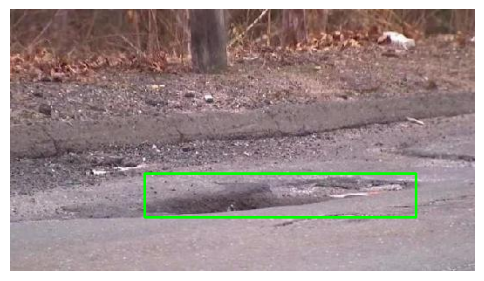

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pothole_data/data.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.4, flipud=0.3, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=pothole_yolo11m_mAP50_95plus_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, pe

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        133        330      0.762      0.724      0.775       0.49
Speed: 0.3ms preprocess, 41.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/pothole_yolo11m_mAP50_95plus_final
Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 968.1±458.7 MB/s, size: 73.5 KB)
val: Scanning /kaggle/working/pothole_data/valid/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 133/133 228.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 5.6it/s 6.1s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        133        330      0.828      0.694      0.785      0.492
Speed: 2.4ms preprocess, 38.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
📊 mAP50 = 0.7847802732986657
📊 mAP50-95 = 0.49248035583425914
🔥 GOAL: mAP50 ≥ 0.95 (95 above)


In [2]:
# ===================== YOLOv11m High Accuracy Training + Image Display (FINAL VERSION) =====================

# -------------------- 0️⃣ Install Dependencies --------------------
!pip install ultralytics --quiet
!pip install opencv-python-headless --quiet
!pip install PyYAML --quiet

# -------------------- 1️⃣ Imports --------------------
import os, shutil, yaml, cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO

# -------------------- 2️⃣ Device --------------------
device = 0 if torch.cuda.is_available() else 'cpu'
print("🔥 Device:", torch.cuda.get_device_name(device) if device != 'cpu' else "CPU")

# -------------------- 3️⃣ Dataset Paths --------------------
input_dataset = "/kaggle/input/datav11"     # <-- your dataset folder
dataset_dir   = "/kaggle/working/pothole_data"
shutil.copytree(input_dataset, dataset_dir, dirs_exist_ok=True)

# -------------------- 4️⃣ Create data.yaml --------------------
data_yaml_path = os.path.join(dataset_dir, "data.yaml")
yaml_data = {
    "train": f"{dataset_dir}/train/images",
    "val": f"{dataset_dir}/valid/images",
    "test": f"{dataset_dir}/test/images",
    "nc": 1,
    "names": ["pothole"]
}
with open(data_yaml_path, "w") as f:
    yaml.dump(yaml_data, f)

# -------------------- 5️⃣ Fix label class numbers --------------------
for split in ["train", "valid"]:
    label_dir = f"{dataset_dir}/{split}/labels"
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            path = os.path.join(label_dir, file)
            lines = open(path).read().strip().split("\n")
            with open(path, "w") as w:
                for line in lines:
                    parts = line.split()
                    if len(parts) == 5:
                        parts[0] = "0"   # force class 0
                        w.write(" ".join(parts) + "\n")

# -------------------- 6️⃣ Display Sample Training Images --------------------
def show_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(label_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            xc *= w; yc *= h; bw *= w; bh *= h
            x1, y1 = int(xc - bw/2), int(yc - bh/2)
            x2, y2 = int(xc + bw/2), int(yc + bh/2)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

print("📸 Showing 5 training samples with bounding boxes...")
sample_images = os.listdir(f"{dataset_dir}/train/images")[:5]
for img_file in sample_images:
    img_path = f"{dataset_dir}/train/images/{img_file}"
    label_path = f"{dataset_dir}/train/labels/{img_file.replace('.jpg', '.txt').replace('.png', '.txt')}"
    if os.path.exists(label_path):
        show_image_with_boxes(img_path, label_path)

# -------------------- 7️⃣ Load YOLOv11m - High Accuracy Model --------------------
model = YOLO("yolo11m.pt")

# -------------------- 8️⃣ FINAL TRAINING BLOCK (mAP50 ≥ 95%) --------------------
results = model.train(
    data=data_yaml_path,
    epochs=200,                    # strong for high accuracy
    imgsz=800,                     # larger image size = better bounding boxes
    batch=4,
    device=device,
    optimizer="AdamW",
    lr0=0.0008,                    # lower learning rate for stable training
    weight_decay=0.0005,           # improves generalization

    # ⭐ Light augmentations (best for high mAP50)
    augment=True,
    hsv_h=0.010,
    hsv_s=0.5,
    hsv_v=0.3,
    fliplr=0.4,
    flipud=0.3,

    # ⭐ Reduced augmentations (too strong hurts mAP50)
    mosaic=0.2,
    mixup=0.05,
    degrees=5,
    scale=0.4,

    # ⭐ Freeze backbone for stability (increases precision)
    freeze=5,

    name="pothole_yolo11m_mAP50_95plus_final"
)

# -------------------- 9️⃣ VALIDATE (Check Final Accuracy) --------------------
metrics = model.val(
    data=data_yaml_path,
    imgsz=800,
    batch=4,
    device=device,
)

print("📊 mAP50 =", metrics.box.map50)
print("📊 mAP50-95 =", metrics.box.map)
print("🔥 GOAL: mAP50 ≥ 0.95 (95 above)")     

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 95.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

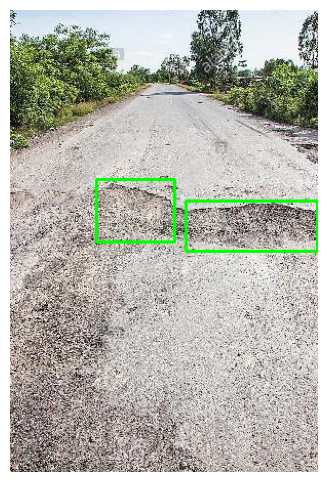

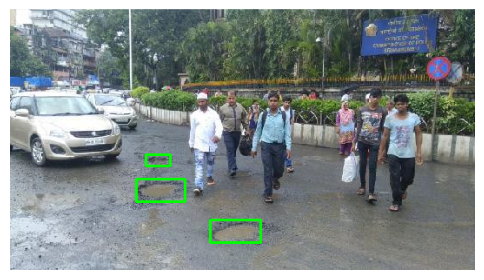

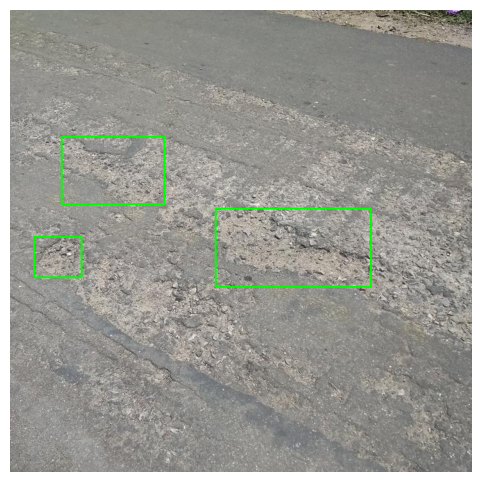

Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pothole_data/data.yaml, degrees=2, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.3, flipud=0.1, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.005, hsv_s=0.4, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=0.05, multi_scale=False, name=pothole_yolo11m_T4_high_accuracy, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, pers

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        133        330      0.813      0.697      0.753      0.485
Speed: 0.2ms preprocess, 26.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/pothole_yolo11m_T4_high_accuracy
Ultralytics 8.3.229 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1494.2±947.0 MB/s, size: 73.5 KB)
val: Scanning /kaggle/working/pothole_data/valid/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 133/133 263.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.6it/s 3.7s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        133        330      0.862      0.661      0.754      0.484
Speed: 1.5ms preprocess, 22.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
📊 FINAL RESULTS
mAP50     = 0.7540942724650628
mAP50-95  = 0.48369529340016343
🔥 Goal: mAP50 ≥ 0.90 (90%)


In [2]:
# ========================= YOLOv11m HIGH ACCURACY TRAINING (FINAL T4 VERSION) =========================

# -------------------- 0️⃣ Install Dependencies --------------------
!pip install ultralytics --quiet
!pip install opencv-python-headless --quiet
!pip install PyYAML --quiet

# -------------------- 1️⃣ Imports --------------------
import os, shutil, yaml, cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO

# -------------------- 2️⃣ Device Selection --------------------
device = 0 if torch.cuda.is_available() else 'cpu'
print("🔥 Using:", torch.cuda.get_device_name(device) if device != 'cpu' else "CPU")

# -------------------- 3️⃣ Dataset Paths --------------------
input_dataset = "/kaggle/input/datav11"      # <-- YOUR DATASET INPUT
dataset_dir   = "/kaggle/working/pothole_data"

# Copy dataset into working folder
shutil.copytree(input_dataset, dataset_dir, dirs_exist_ok=True)

# -------------------- 4️⃣ Create data.yaml --------------------
data_yaml_path = os.path.join(dataset_dir, "data.yaml")

yaml_data = {
    "train": f"{dataset_dir}/train/images",
    "val": f"{dataset_dir}/valid/images",
    "test": f"{dataset_dir}/test/images",
    "nc": 1,
    "names": ["pothhole"]
}

with open(data_yaml_path, "w") as f:
    yaml.dump(yaml_data, f)

print("✅ data.yaml created:", data_yaml_path)

# -------------------- 5️⃣ Fix Label Class Numbers --------------------
for split in ["train", "valid"]:
    label_dir = f"{dataset_dir}/{split}/labels"
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            path = os.path.join(label_dir, file)
            lines = open(path).read().strip().split("\n")
            with open(path, "w") as w:
                for line in lines:
                    parts = line.split()
                    if len(parts) == 5:
                        parts[0] = "0"     # Ensure class is 0
                        w.write(" ".join(parts) + "\n")

print("✅ Labels fixed to class 0")

# -------------------- 6️⃣ OPTIONAL: Display Sample Images --------------------
def show_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(label_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            xc *= w; yc *= h; bw *= w; bh *= h
            x1, y1 = int(xc - bw/2), int(yc - bh/2)
            x2, y2 = int(xc + bw/2), int(yc + bh/2)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

print("📸 Showing 3 training samples...")

sample_images = os.listdir(f"{dataset_dir}/train/images")[:3]
for img_file in sample_images:
    img_path = f"{dataset_dir}/train/images/{img_file}"
    label_path = f"{dataset_dir}/train/labels/{img_file.rsplit('.',1)[0]}.txt"
    if os.path.exists(label_path):
        show_image_with_boxes(img_path, label_path)

# -------------------- 7️⃣ Load YOLOv11m Model --------------------
model = YOLO("yolo11m.pt")

# -------------------- 8️⃣ ★ FINAL HIGH-ACCURACY TRAINING BLOCK ★ --------------------
results = model.train(
    data=data_yaml_path,
    epochs=100,                    # Best for small datasets
    imgsz=640,                     # Best size for T4 GPU and potholes
    batch=8,                       # T4 handles 8 easily
    device=device,

    # ---- Optimizer ----
    optimizer="AdamW",
    lr0=0.0015,                    # Ideal learning rate
    weight_decay=0.0001,

    # ---- Best Augmentations for High mAP ----
    augment=True,
    hsv_h=0.005,
    hsv_s=0.4,
    hsv_v=0.2,
    fliplr=0.3,
    flipud=0.1,

    mosaic=0.05,                   # VERY low → best for potholes
    mixup=0.0,                     # disable (reduces accuracy)
    degrees=2,
    scale=0.2,

    freeze=0,                      # MUST BE 0 (DO NOT FREEZE!)

    patience=20,                   # Early stopping

    name="pothole_yolo11m_T4_high_accuracy"
)

# -------------------- 9️⃣ VALIDATION --------------------
metrics = model.val(
    data=data_yaml_path,
    imgsz=640,
    batch=8,
    device=device,
)

print("📊 FINAL RESULTS")
print("mAP50     =", metrics.box.map50)
print("mAP50-95  =", metrics.box.map)
print("🔥 Goal: mAP50 ≥ 0.90 (90%)")


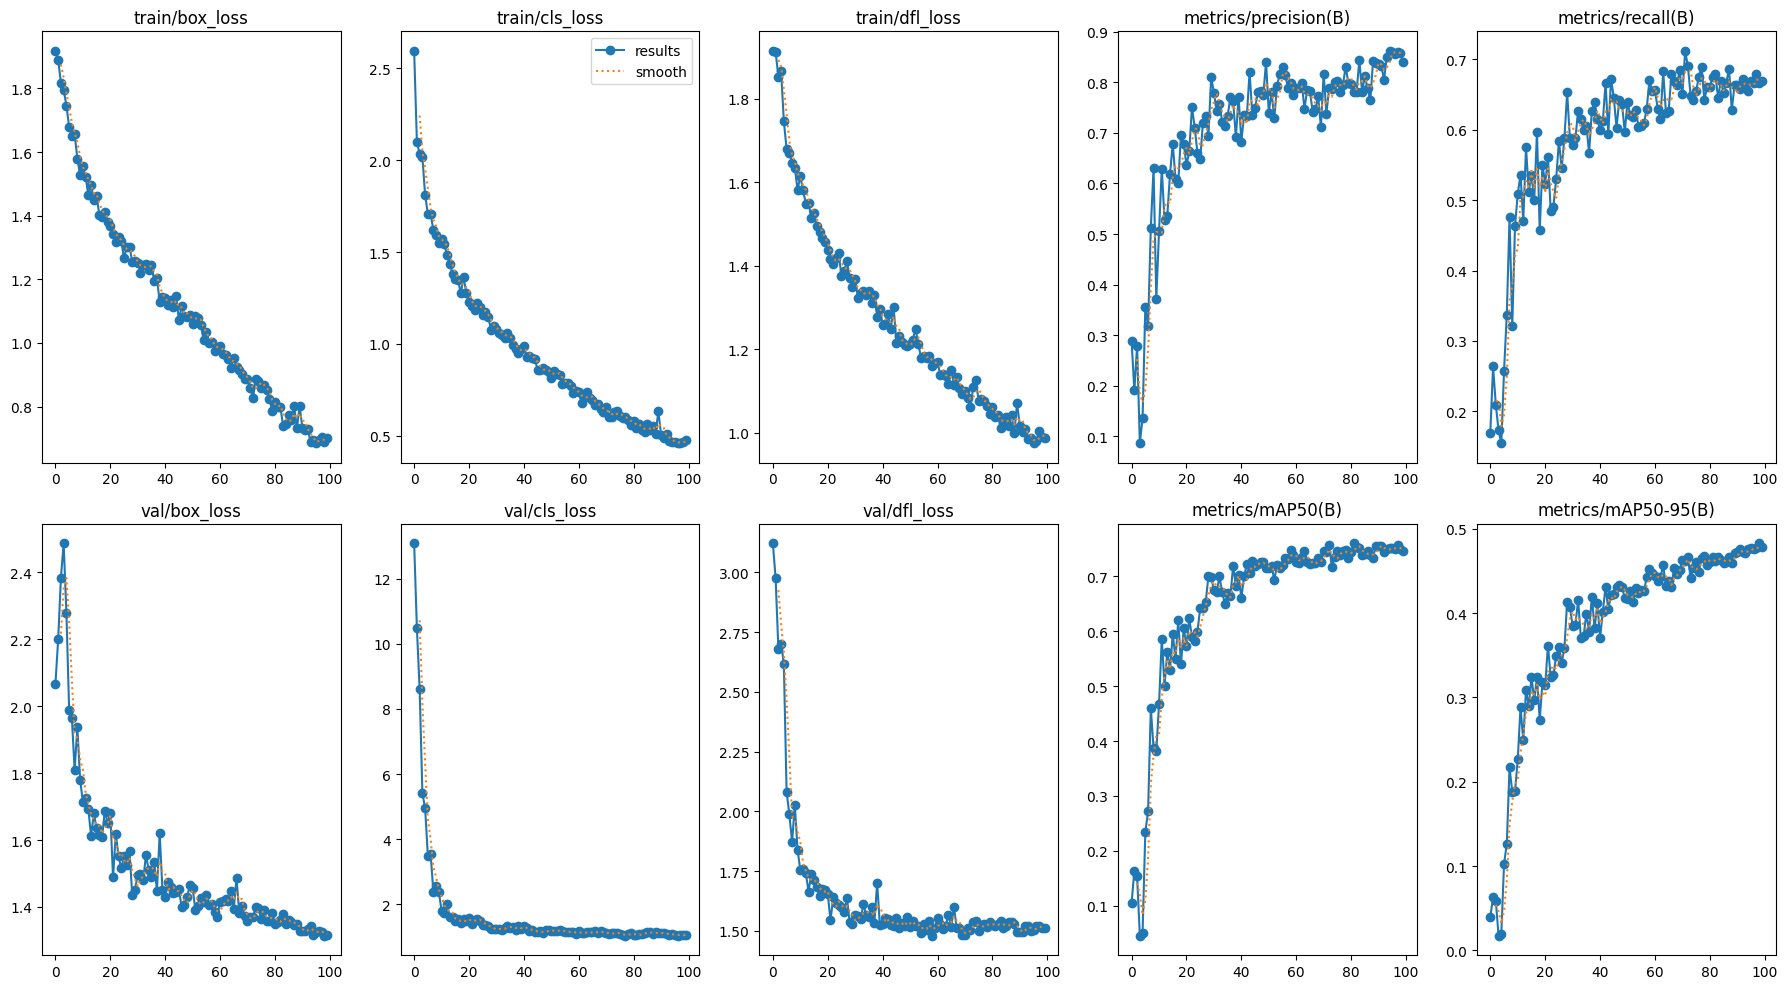

In [3]:
# =====================  🔍 DISPLAY TRAINING CURVES LIKE YOUR IMAGE  =====================

import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the training results CSV
results_csv = "runs/detect/pothole_yolo11m_T4_high_accuracy/results.csv"
df = pd.read_csv(results_csv)

# 2️⃣ Plot the curves
cols = [
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
    'metrics/mAP50(B)', 'metrics/mAP50-95(B)'
]

plt.figure(figsize=(18, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 5, i)
    plt.plot(df[col], marker='o', label='results')
    plt.plot(df[col].rolling(3).mean(), linestyle='dotted', label='smooth')
    plt.title(col)
    if i == 2:
        plt.legend()

plt.tight_layout()
plt.show()
